# 1. Motivation

* **What is your dataset?**

The dataset we used is based on the NYPD Motor Vehicle Collisions, it can be found [here](https://data.cityofnewyork.us/Public-Safety/Heat-map/9dh2-x3up), and it comprehends all the traffic accidents in the city of New York from 2012 until the present. For most of the accidents, it contains information about the date, hour, borough, zip code, exact location, persons injured, persons killed, contributing factors and the type of vehicles involved. Moreover, the number of persons injured/killed is further classified into pedestrians/cyclists/motorists and others, such as car/truck drivers.

* **Why did you choose this particular dataset?**

We chose this particular dataset because it has a lot of data of each accident that we could use to extract relevant conclusions. Particularly, we liked that it contains localization data, which is very interesting to make nice visualizations. 

* **What was your goal for the end user's experience?**

Our goal was to show the end user different plots that are easy to understand and to present some interesting results regarding road accidents in the city of New York. In this way, we used several bar plots, a Bubble chart, and a heatmap with the accidents in NYC. Moreover, we also wanted to present the end user with the results of some machine learning tools that could be used to make predictions on future accidents or find the best location for fire or police stations. For this reason, we used K-means and decision trees.

All of these results are presented in a [website](https://nestorbonjorn.github.io/SocialDataProject/), with plenty of interactive graphics (made using D3) and the proper explanation and analysis of the results.

# 2. Basic stats

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (13,8)
import random as rand
from pandas import DataFrame, read_csv
import pandas as pd
from sklearn.cluster import KMeans
from math import sqrt
from collections import defaultdict, Counter
import re
from __future__ import division
from datetime import date
import csv
import json
from IPython.display import Image

In [2]:
#path = ""
path = "/Users/Ferran/Downloads/"
#path = "C:\Users\Nestor Bonjorn\Documents\Datasets\\"
filename = "NYC_accidents_heat_map.csv"
# Read CSV data with Pandas formatting
table = pd.read_csv(path+filename, low_memory=False)

* **Data cleaning and preprocessing**

Once the dataset is downloaded, the first thing to do is to keep with data from 2012 to 2016. We discarded data from 2017 in order to only have data of complete years.

In [3]:
years = [str(year) for year in range(2012,2017)]
data = table[table["DATE"].str.extract(r'\d+/\d+/(\d+)', expand=False).isin(years)].reset_index()

Moreover, for the analysis that need localization data, we remove the accidents from the the dataset that have this information missing

In [4]:
data_without_nan = data.dropna(subset = ["BOROUGH", "ZIP CODE", "LATITUDE", "LONGITUDE"])

Finally, we did some preprocessing to analyze the contributing factors. First, we join the 5 contributing factors in a single dictionary, and then we substract "NaN" and "Unspecified" factors, for all the accidents and for accidents with at least one death.

In [5]:
frames = []
for i in range (1,6):
    frames.append(data_without_nan["CONTRIBUTING FACTOR VEHICLE %d" %i].fillna("NaN"))
contributing_factors = pd.concat(frames)

contributing_factors_dict = Counter(contributing_factors)
contributing_factors_dict.pop("NaN")
contributing_factors_dict.pop("Unspecified")


accidents_with_deaths = data_without_nan[data_without_nan["NUMBER OF PERSONS KILLED"] > 0]
frames = []
for i in range (1,6):
    frames.append(accidents_with_deaths["CONTRIBUTING FACTOR VEHICLE %d" %i].fillna("NaN"))
contributing_factors_deaths = pd.concat(frames)

contributing_factors_dict_deaths = Counter(contributing_factors_deaths)
contributing_factors_dict_deaths.pop("NaN")
contributing_factors_dict_deaths.pop("Unspecified")

722

* **Dataset stats**

**BAR PLOTS**

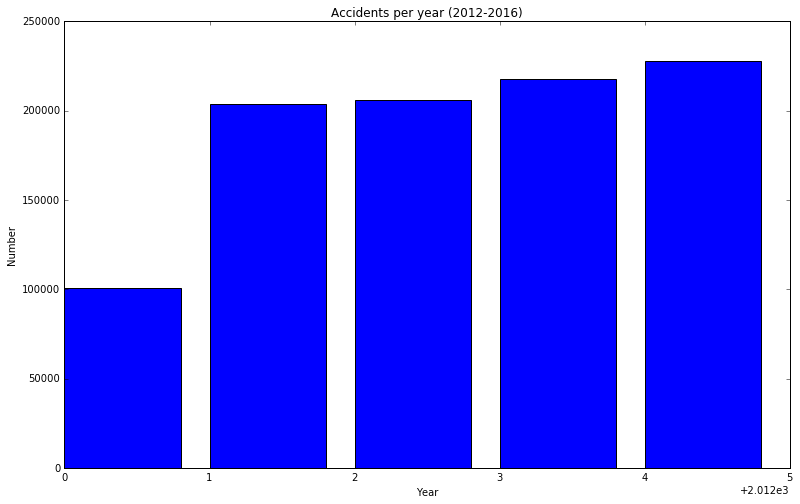

In [6]:
accidents_by_year_dict = defaultdict(int)
for i in xrange(len(data)):
    accidents_by_year_dict[int(data["DATE"][i][-4:])] += 1

plt.bar(accidents_by_year_dict.keys(), accidents_by_year_dict.values())
plt.title('Accidents per year (2012-2016)')
plt.ylabel('Number')
plt.xlabel('Year')
plt.show()

In the previous figure we can see that the number of accidents is slightly increasing over the years. There's a huge difference between 2012 and 2013, but it is probably because information from 2012 is missing.

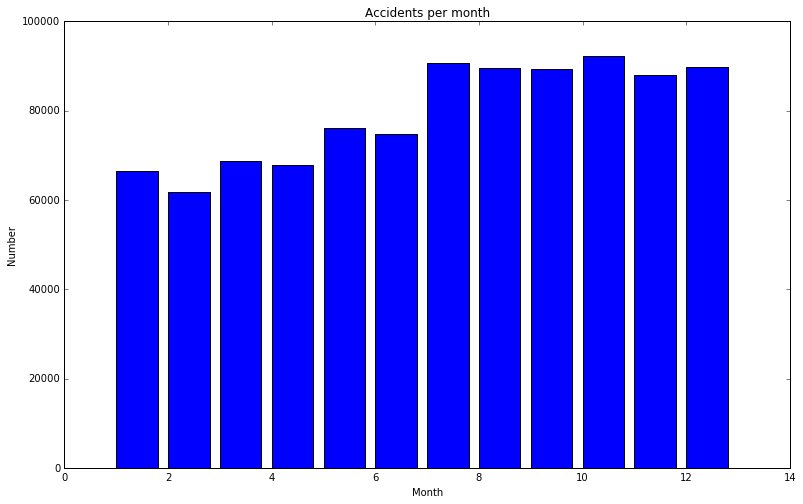

In [7]:
accidents_by_month_dict = defaultdict(int)

for i in xrange(len(data)):
    accidents_by_month_dict[int(data["DATE"][i][:2])] += 1

plt.bar(accidents_by_month_dict.keys(), accidents_by_month_dict.values())
plt.title('Accidents per month')
plt.ylabel('Number')
plt.xlabel('Month')
plt.show()

Analysing the accidents per month of the year, we can see that there are more accidents in the second half of the year, with a maximum in October. We can't figure out a reason to this.

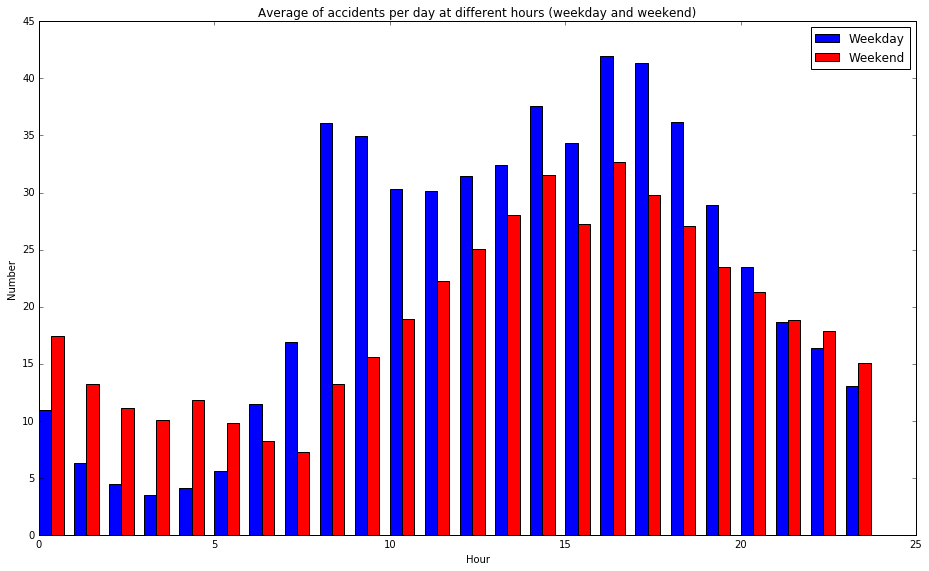

In [8]:
accidents_by_hour_types = {k:{'Weekday': 0, 'Weekend':0} for k in xrange(24)}
for i in xrange(len(data)):
    dt  = data["DATE"][i]
    month, day, year = (int(x) for x in dt.split('/'))
    weekday = date(year, month, day).weekday()
    if weekday > 4: # Weekend
        accidents_by_hour_types[int(re.search(r'(\d+):', data["TIME"][i]).group(1))]["Weekend"] += 1
    else: # Weekday
        accidents_by_hour_types[int(re.search(r'(\d+):', data["TIME"][i]).group(1))]["Weekday"] += 1

# We divide by the number of week days/weekend days of a year (260 and 105, respectively)
# and by 5 years, to get the average per year
weekdays = [accidents_by_hour_types[k]["Weekday"]/260/5 for k in xrange(24)]
weekends = [accidents_by_hour_types[k]["Weekend"]/105/5 for k in xrange(24)]

n_groups = 24
index = np.arange(n_groups)
bar_width = 0.35

rects1 = plt.bar(index, weekdays, bar_width,
                 color='b',
                 label='Weekday')

rects2 = plt.bar(index + bar_width, weekends, bar_width,
                 color='r',
                 label='Weekend')

plt.title('Average of accidents per day at different hours (weekday and weekend)')
plt.ylabel('Number')
plt.xlabel('Hour')
plt.legend()
plt.tight_layout()
plt.show()

We can see that in the weekdays there are two clear maximums in the rush hours (8:00 - 9:59 and 16:00 - 17:59). On the other hand, accidents during the weekends are in general lower than in the weekdays, except for the night time (21:00 - 5:59), since it is the time when people go out and drive drunk.

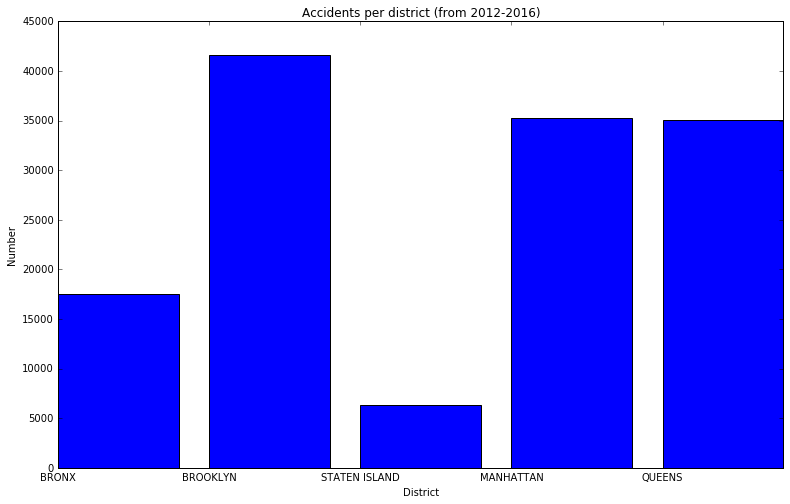

In [9]:
accidents_by_neighbourhood_no_nan = defaultdict(int)
for i in data_without_nan.index:
    accidents_by_neighbourhood_no_nan[data["BOROUGH"][i]] += 1

x = xrange(len(accidents_by_neighbourhood_no_nan.keys()))
plt.xticks(x, accidents_by_neighbourhood_no_nan.keys())
plt.bar(x, 1/5*np.array(accidents_by_neighbourhood_no_nan.values()))
plt.title('Accidents per district (from 2012-2016)')
plt.ylabel('Number')
plt.xlabel('District')
plt.show()

The previous plot shows the amount of accidents per district. We can see that Brooklyn is the district with more accidents, however;  it is can depend on other factors, such as the population density or the area of each district.

In [10]:
boroughs_data = {'MANHATTAN':
                     {'Population': 1643734,
                           'Area' : 58.68},
                 'BRONX':
                     {'Population': 1455720,
                           'Area' : 108.91},
                 'BROOKLYN':
                     {'Population': 2629150,
                           'Area' : 180.81},
                 'QUEENS':
                     {'Population': 2333054,
                           'Area' : 281.71},
                 'STATEN ISLAND':
                     {'Population': 476015,
                           'Area' : 150.68}}

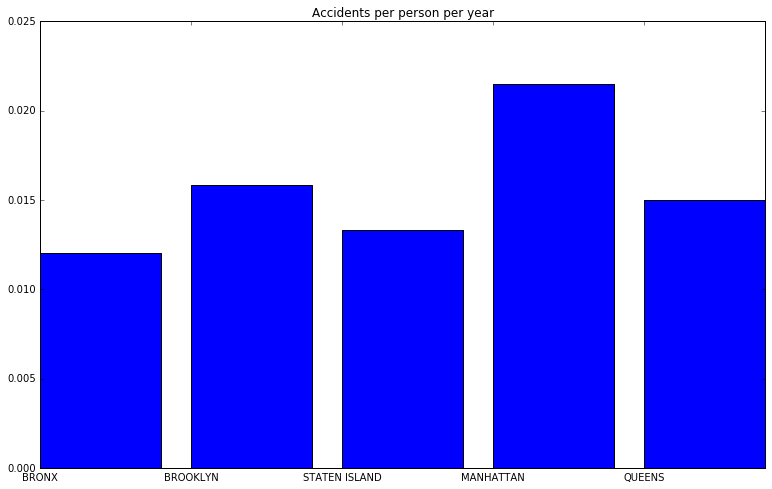

In [11]:
accidents_by_neighbourhood_no_nan_population = {k:0 for k in accidents_by_neighbourhood_no_nan.keys()}

for k in accidents_by_neighbourhood_no_nan_population.keys():
    accidents_by_neighbourhood_no_nan_population[k] = 1/5*accidents_by_neighbourhood_no_nan[k]/boroughs_data[k]['Population']
    
plt.xticks(x, accidents_by_neighbourhood_no_nan.keys())
plt.bar(x, accidents_by_neighbourhood_no_nan_population.values())
plt.title("Accidents per person per year")
plt.show()

Normalizing by the population of each district, we can see that Manhattan has the biggest rate of accidents per person, instead of Brooklyn, that is the most populated district.

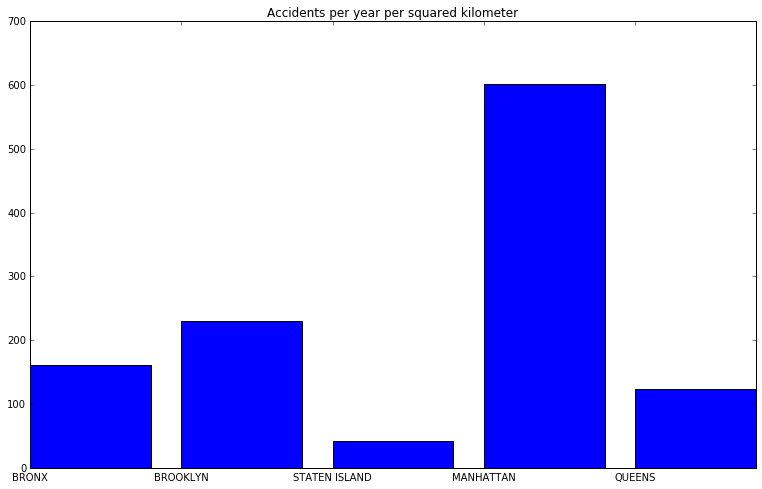

In [12]:
accidents_by_neighbourhood_no_nan_area = {k:0 for k in accidents_by_neighbourhood_no_nan.keys()}

for k in accidents_by_neighbourhood_no_nan_area.keys():
    accidents_by_neighbourhood_no_nan_area[k] = 1/5*accidents_by_neighbourhood_no_nan[k]/boroughs_data[k]['Area']
    
plt.xticks(x, accidents_by_neighbourhood_no_nan.keys())
plt.bar(x, accidents_by_neighbourhood_no_nan_area.values())
plt.title("Accidents per year per squared kilometer")
plt.show()

Here, the clear winner is Manhattan, since it is a very small neighborhood, but it is the most densely-populated and crowded borough of New York City.

In [13]:
accidents_by_year_types = {year:{'No injuries': 0, 'Injuries':0, 'Death':0} for year in years}
for i in xrange(len(data)):
    if(data["NUMBER OF PERSONS INJURED"][i] == 0 and data["NUMBER OF PERSONS KILLED"][i] == 0):
        accidents_by_year_types[data["DATE"][i][-4:]]['No injuries'] += 1
    else:
        if(data["NUMBER OF PERSONS INJURED"][i] > 0): accidents_by_year_types[data["DATE"][i][-4:]]['Injuries'] += 1
        if(data["NUMBER OF PERSONS KILLED"][i] > 0): accidents_by_year_types[data["DATE"][i][-4:]]['Death'] += 1

no_injuries = [accidents_by_year_types[year]["No injuries"] for year in years]
injuries = [accidents_by_year_types[year]["Injuries"] for year in years]
death = [accidents_by_year_types[year]["Death"] for year in years]

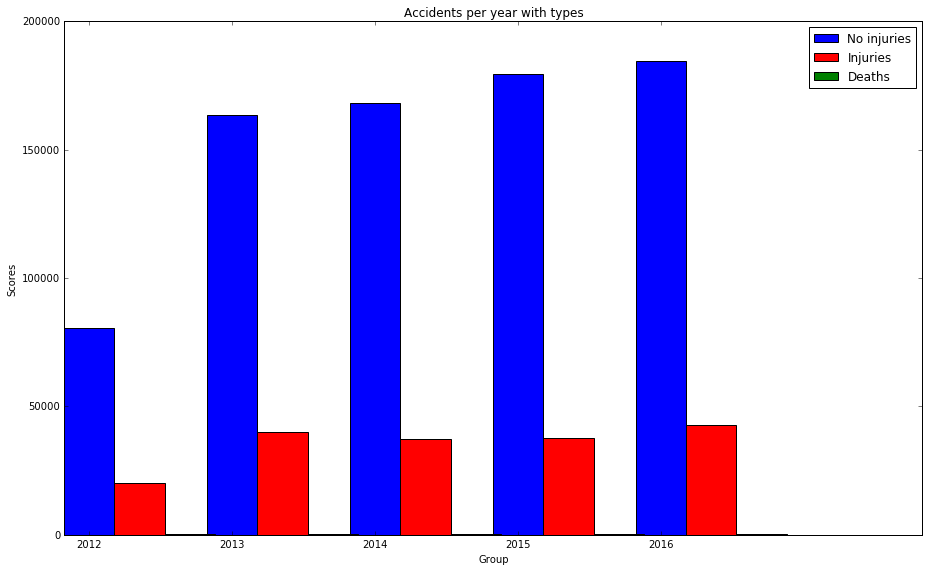

In [14]:
n_groups = 5
index = np.arange(n_groups)
bar_width = 0.35

rects1 = plt.bar(index, no_injuries, bar_width,
                 color='b',
                 label='No injuries')

rects2 = plt.bar(index + bar_width, injuries, bar_width,
                 color='r',
                 label='Injuries')

rects3 = plt.bar(index + 2*bar_width, death, bar_width,
                 color='g',
                 label='Deaths')

plt.xlabel('Group')
plt.ylabel('Scores')
plt.title('Accidents per year with types')
plt.xticks(index + bar_width / 2, years)
plt.legend()
plt.tight_layout()
plt.show()

It is very interesting to analyze the evolution of the number of accidents, separating them by the consequences of these accidents, that is: no injuries, injuries or deaths. We can see that the number of accidents without injuries is increasing at a similar rate as the total (since it represents the majority of the accidents) and the number of accidents with injured people is quite stable around 37.500. It cannot be seen in the previous plot (rects1 and rects2 should be commented to only show deaths), but the number of deaths is decreasing year over year. This is probably because of the active and passive safety systems installed in new cars, the increase in the cost of traffic fines or a better social consciousness.

**ACCIDENTS MAP**

We prepared two different types of maps. One with the location of all the accidents, but only displaying around the 10% of it (to avoid the website to run slowly), and the other with the location of the fatal accidents. In the following code, the csv is generated in order to work with this data in the website.

In [15]:
with open('geoAccidentsNormLabel.csv','wb') as f:
    w = csv.writer(f)
    w.writerow(('lat', 'lon', 'year', 'label'))
    for year in years:
        data_year = data_without_nan[data_without_nan["DATE"].str.extract(r'\d+/\d+/(\d+)', expand=False) == str(year)]
        index = rand.sample(list(data_year.index), 2000)
        data_year = data_year.loc[index]
        for i in data_year.index:
            if(data["NUMBER OF PERSONS KILLED"][i] > 0): label = 2
            elif(data["NUMBER OF PERSONS INJURED"][i] > 0): label = 1
            else: label = 0
            
            w.writerow([data_without_nan["LATITUDE"][i], 
                        data_without_nan["LONGITUDE"][i],
                        str(year),
                        label])

killed_map = data_without_nan[data_without_nan["NUMBER OF PERSONS KILLED"]>0]
with open('geoAccidentskilled.csv','wb') as f:
    w = csv.writer(f)
    w.writerow(('lat', 'lon', 'year'))
    for i in killed_map.index:
        w.writerow([data_without_nan["LATITUDE"][i], 
                        data_without_nan["LONGITUDE"][i],
                        data_without_nan["DATE"][i][-4:]])

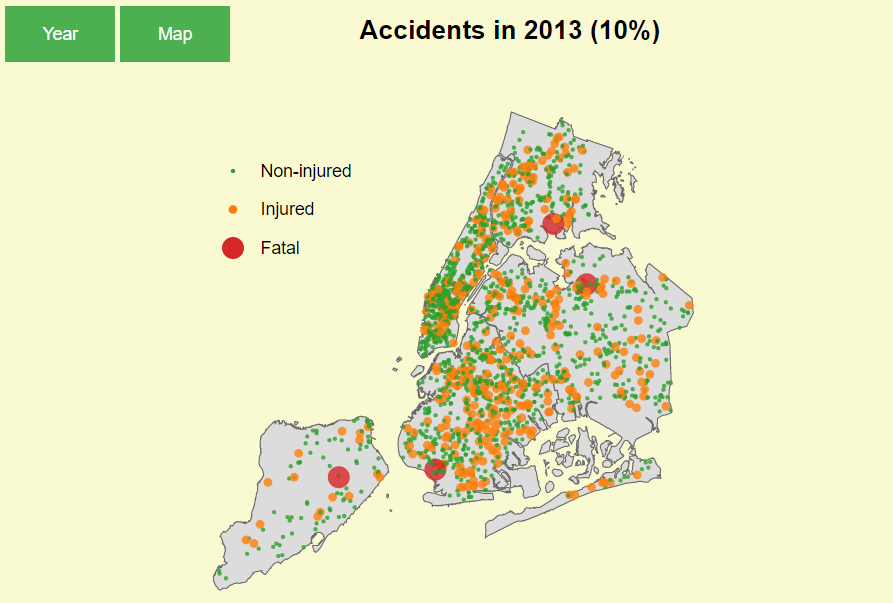

In [16]:
Image(filename = "accidents_map.png")

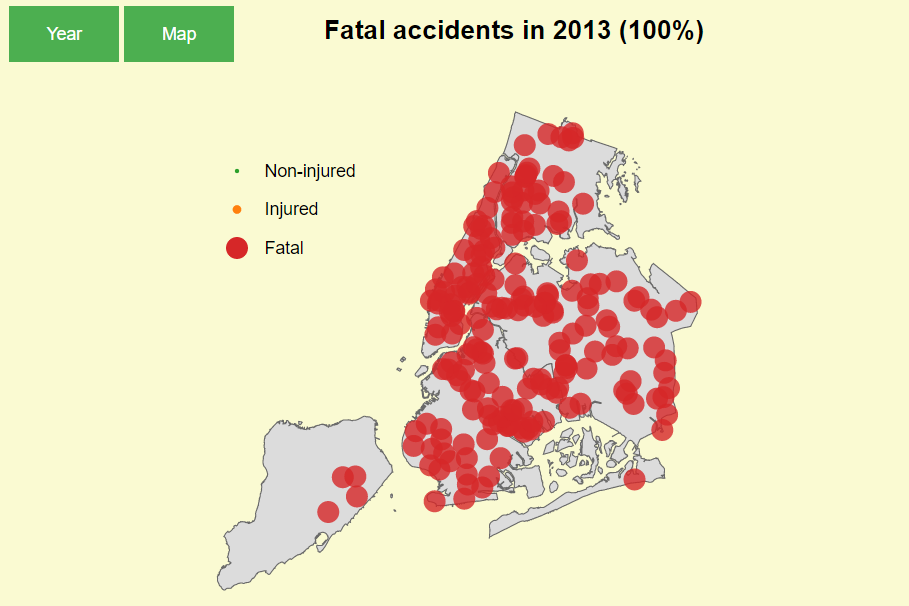

In [17]:
Image(filename = "deaths_map.png")

In the top picture, we can see the distribution of accidents separated by their consequences (10% of accidents aprox.) and in the bottom only the fatal ones.

# 3. Theory

## Machine learning tools

We have used two different machine learning tools: K-means and decision trees.
K-means clustering aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. It our project, we use it to find the optimal location of fire stations, so the overall distance from each accident location to its centroid is minimized.

We use decision trees to classify accidents according to a list of given parameter. In this way, we can use this classifier to predict some characteristics of the future accidents.

## Model selection

For both the K-means and the decision tree, we split the data into train, with the accidents between 2012 and 2016, and test, with the data of the first months of 2017.

## Model performance

### K-MEANS

In [18]:
accidents_excluding_no_injuries = data_without_nan[(data_without_nan["NUMBER OF PERSONS INJURED"] > 0) | (data_without_nan["NUMBER OF PERSONS KILLED"] > 0)]

list_of_lat = list(accidents_excluding_no_injuries["LATITUDE"])
list_of_lon = list(accidents_excluding_no_injuries["LONGITUDE"])
X = np.array(zip(list_of_lat, list_of_lon))

means = [KMeans(n_clusters=i, random_state=0).fit(X) for i in range(2,7)]
labels = [means[i].labels_.tolist() for i in xrange(len(means))]

centroids = {"kmeans%d"%i:means[i-2].cluster_centers_.tolist() for i in range(2,7)}

In [47]:
with open('kmeans_10.csv','wb') as f:
    w = csv.writer(f)
    w.writerow(('lat', 'lon', 'l2', 'l3', 'l4', 'l5', 'l6'))
    for i in xrange(len(list_of_lat)):
        if (rand.randint(1,10) == 1):
            w.writerow([list_of_lat[i], 
                        list_of_lon[i],
                        labels[0][i],
                        labels[1][i],
                        labels[2][i],
                        labels[3][i],
                        labels[4][i]])

In [49]:
test = table[table["DATE"].str.extract(r'\d+/\d+/(\d+)', expand=False).isin(["2017"])]
test_no_nan = test.dropna(subset = ["BOROUGH", "ZIP CODE", "LATITUDE", "LONGITUDE"])
test_no_nan = test_no_nan[test_no_nan["LATITUDE"]>0]

In [51]:
accidents_excluding_no_injuries_2017 = test_no_nan[(test_no_nan["NUMBER OF PERSONS INJURED"] > 0) | (test_no_nan["NUMBER OF PERSONS KILLED"] > 0)]

In [52]:
list_of_lat_2017 = list(accidents_excluding_no_injuries_2017["LATITUDE"])
list_of_lon_2017 = list(accidents_excluding_no_injuries_2017["LONGITUDE"])
X_2017 = np.array(zip(list_of_lat_2017, list_of_lon_2017))

means_2017 = [KMeans(n_clusters=i).fit(X_2017) for i in range(2,7)]
labels_2017 = [means_2017[i].labels_.tolist() for i in xrange(len(means_2017))]

centroids_2017 = {"kmeans%d"%i:means_2017[i-2].cluster_centers_.tolist() for i in range(2,7)}

In [53]:
def DirectDistance (lat1, lon1, lat2, lon2):
    earthRadius = 3948.75
    dLat = np.deg2rad(lat2-lat1)
    dLon = np.deg2rad(lon2-lon1)
    a = np.sin(dLat/2)*np.sin(dLat/2) + np.cos(np.deg2rad(lat1)*np.cos(np.deg2rad(lat2)))*np.sin(dLon/2)*np.sin(dLon/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    dist = earthRadius*c
    meterConversion = 1609.00
    return dist*meterConversion

def closestCenter(point, centers):
    distances = [DirectDistance(point[0], point[1], p[0], p[1]) for p in centers]
    return centers[distances.index(min(distances))]

dist_k = [0]*len(range(2,7))
for i in range(2,7):
    kmeans = "kmeans" + str(i)
    points = centroids[kmeans]
    points2017 = centroids_2017[kmeans]
    for p in xrange(i):
        closest_center = closestCenter(centroids_2017[kmeans][p], centroids[kmeans])
        dist_k[i-2] = dist_k[i-2] + DirectDistance(centroids_2017[kmeans][p][0],
                                               centroids_2017[kmeans][p][1],
                                               closest_center[0],
                                               closest_center[1])
    dist_k[i-2]/= i

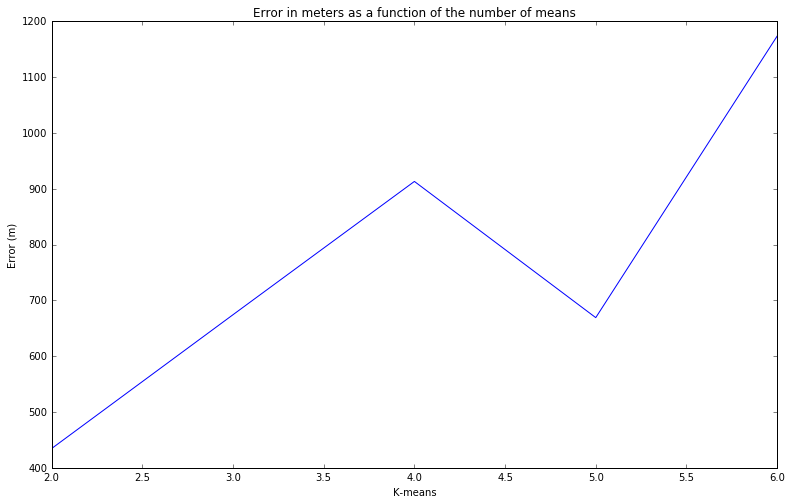

In [54]:
plt.plot(range(2,7), dist_k)
plt.title("Error in meters as a function of the number of means")
plt.xlabel("K-means")
plt.ylabel("Error (m)")
plt.show()

We can see that the cluster centers calculated with the data of 2017 are quite similar to the centers with the data of the other years, with a maximum distance of around 1 km. The two smallest values are for k=2 and for k=5. However, if we take into account the average distance to the center (picture below) we can see that the ideal number of clusters is 5, since it has a small error and at the same time a smaller distance to the cluster centers.

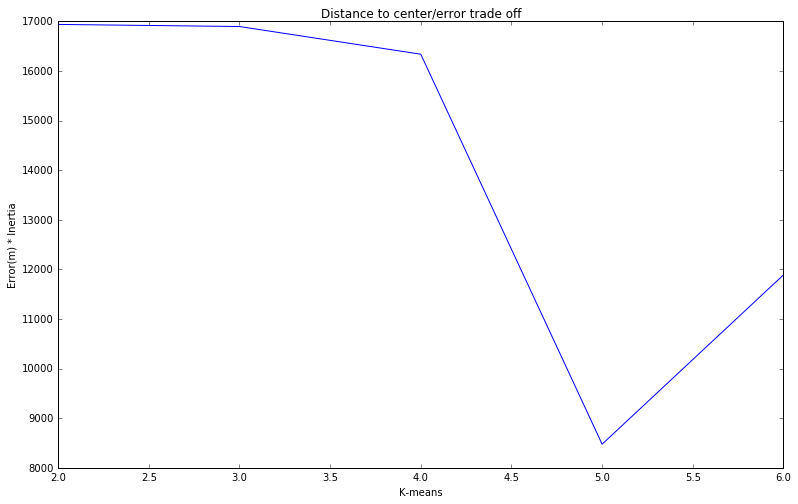

In [55]:
plt.plot(range(2,7),np.array([means_2017[i-2].inertia_ for i in xrange(2,7)])*dist_k)
plt.xlabel("K-means")
plt.ylabel("Error(m) * Inertia")
plt.title("Distance to center/error trade off")
plt.show()

### DECISION TREE

In [56]:
import urllib2
from scipy import stats
from IPython.display import display
from sklearn import tree
from operator import itemgetter
import re
import operator

#### Getting the dataset and the training and testing data

In [57]:
years_test = ["2017"]
table_training = table[~table["DATE"].str.extract(r'\d+/\d+/(\d+)', expand=False).isin(years_test)]
table_testing = table[table["DATE"].str.extract(r'\d+/\d+/(\d+)', expand=False).isin(years_test)]

#### Training

##### Get the data [Hour, DayOfWeek, Factor, NumberOfVehicles] and the target (Number of killed people) for the tree classifier with the training data (2012-2016)**

In [58]:
data = np.array([[0,0,0,0]]*len(table_training))
target = np.array([0]*len(table_training))

### Data 1 (PartOfDay)
hours = map(int, table_training["TIME"].str.extract(r'(\d+):', expand=False))

# We specify groups of hours
hours_set = list(set(hours))
transdict_hours = {hours_set[i]: i for i in xrange(len(hours_set))}
for h in xrange(len(hours_set)):
    if (h >= 0 and h <= 5):
        transdict_hours[h] = 0
    elif (h >= 6 and h <= 10):
        transdict_hours[h] = 1
    elif (h >= 11 and h <= 14):
        transdict_hours[h] = 2
    elif (h >= 15 and h <= 17):
        transdict_hours[h] = 3
    elif (h >= 18 and h <= 23):
        transdict_hours[h] = 4

data[:,0] = [transdict_hours[hour] for hour in hours]

### Data 2 (DayOfWeek)
daysOfWeek = []
for i in table_training.index:
    dt = table_training["DATE"][i]
    month, day, year = (int(x) for x in dt.split('/'))
    weekday = date(year, month, day).weekday()
    daysOfWeek.append(weekday)

data[:,1] = daysOfWeek

### Data 3 (Contributing factor)
factors = table_training["CONTRIBUTING FACTOR VEHICLE 1"]
factors_set = list(set(factors))

transdict_factors = {factors_set[i]: i for i in xrange(len(factors_set))}

data[:,2] = [transdict_factors[factor] for factor in factors]

### Data 4 (Number of vehicles involved)
numberOfVehicles = []
for i in table_training.index:
    for j in range(1,6):
        if (str(table_training["CONTRIBUTING FACTOR VEHICLE %d" % j][i]) == "nan"):
            numberOfVehicles.append(j-1)
            break
    if (str(table_training["CONTRIBUTING FACTOR VEHICLE %d" % 5][i]) != "nan"):
        numberOfVehicles.append(5)
            
data[:,3] = numberOfVehicles

### Target (Number of persons killed)
killed = table_training["NUMBER OF PERSONS KILLED"]

target[:] = killed

##### Create the tree classifier [Hour, DayOfWeek, Factor, NumberOfVehicles] --> Number of killed people

In [59]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(data, target)
tree.export_graphviz(clf, out_file='killed_tree.dot')

#### Testing

##### Get the data [Hour, DayOfWeek, Factor, NumberOfVehicles] and the target (Number of killed people) for the tree classifier testing with the testing data (2017)

In [60]:
data_test = np.array([[0,0,0,0]]*len(table_testing))
target_test = np.array([0]*len(table_testing))


### Data 1 (PartOfDay)
hours = map(int, table_testing["TIME"].str.extract(r'(\d+):', expand=False))
hours_set = list(set(hours))

# We specify groups of hours
transdict_hours = {hours_set[i]: i for i in xrange(len(hours_set))}
for h in xrange(len(hours_set)):
    if (h >= 0 and h <= 5):
        transdict_hours[h] = 0
    elif (h >= 6 and h <= 10):
        transdict_hours[h] = 1
    elif (h >= 11 and h <= 14):
        transdict_hours[h] = 2
    elif (h >= 15 and h <= 17):
        transdict_hours[h] = 3
    elif (h >= 18 and h <= 23):
        transdict_hours[h] = 4

data_test[:,0] = [transdict_hours[hour] for hour in hours]



### Data 2 (DayOfWeek)
daysOfWeek = []
for i in table_testing.index:
    dt = table_testing["DATE"][i]
    month, day, year = (int(x) for x in dt.split('/'))
    weekday = date(year, month, day).weekday()
    daysOfWeek.append(weekday)
    
data_test[:,1] = daysOfWeek



### Data 3 (Contributing factor)
factors = table_testing["CONTRIBUTING FACTOR VEHICLE 1"]
factors_set = list(set(factors))

transdict_factors = {factors_set[i]: i for i in xrange(len(factors_set))}

data_test[:,2] = [transdict_factors[factor] for factor in factors]



### Data 4 (Number of vehicles involved)
numberOfVehicles = []
for i in table_testing.index:
    for j in range(1,6):
        if (str(table_testing["CONTRIBUTING FACTOR VEHICLE %d" % j][i]) == "nan"):
            numberOfVehicles.append(j-1)
            break
    if (str(table_testing["CONTRIBUTING FACTOR VEHICLE %d" % 5][i]) != "nan"):
        numberOfVehicles.append(5)
            
data_test[:,3] = numberOfVehicles


### Target (Number of persons killed)
killed = table_testing["NUMBER OF PERSONS KILLED"]
killed_set = list(set(killed))
target_test[:] = killed

##### Fraction of correct predictions [Hour, DayOfWeek, Factor, NumberOfVehicles] --> Number of killed people

In [61]:
# Tree classifier prediction
numCorrectPredict = 0
prediction_list = []
for i in xrange(len(target_test)):
    prediction = clf.predict(data_test[i].reshape(1,-1))
    prediction_list.append(prediction[0])
    observation = target_test[i]
    if prediction[0] == observation:
        numCorrectPredict += 1
        
# Random prediction
numCorrectPredictRand = 0
for i in xrange(len(target_test)):
    predictionRand = rand.choice(xrange(len(killed_set)))
    observation = target_test[i]
    if predictionRand == observation:
        numCorrectPredictRand += 1
        
# Most common target prediction  
numCorrectPredictMostCommon = Counter(target_test[:]).most_common()[0][1]

fractionCorrectPredict = numCorrectPredict / len(target_test) * 100
fractionCorrectPredictRand = numCorrectPredictRand / len(target_test) * 100
fractionCorrectPredictMostCommon = numCorrectPredictMostCommon / len(target_test) * 100
print("The fraction of correct predictions obtained with the testing data is %.2f %%" % fractionCorrectPredict)
print("The fraction of correct predictions obtained with a random guess is %.2f %%" % fractionCorrectPredictRand)
print("The fraction of correct predictions obtained by choosing the most typical target is %.2f %%" % fractionCorrectPredictMostCommon)

The fraction of correct predictions obtained with the testing data is 99.91 %
The fraction of correct predictions obtained with a random guess is 33.31 %
The fraction of correct predictions obtained by choosing the most typical target is 99.91 %


##### Real target

In [62]:
Counter(target_test[:]).most_common()

[(0, 47308), (1, 41), (2, 1)]

##### Decision tree predictions

In [63]:
Counter(prediction_list).most_common()

[(0, 47350)]

##### Performance evaluation

We have used data from 2012-2016 to create/train the Decision Tree classifier and data from 2017 to test its performance.

The result seems to be good if we look at the fraction of correct prediction of our Decission Tree, which is 99.91 %. However, this is because in the vast majority of accidents there are no deaths and our decision tree predicts always that there are no deaths. In this case, the fraction of correct predictions is not better than the 3rd one that we can see, that it is made by choosing always the most probable result. Actually, it is exactly the same fraction for obvious reasons.

We have tried to use the decision tree with other parameters in other to predict the same target but the results where equal or worse than the one that it can be seen now. So, finally, the chosen parameters in order to predict the number of deaths in an accident are the following: Hour, Day of the Week, Contributing Factor and Number of Vehicles Involved.

We have also tried to use the decision tree for other kind of predicitions such as the hour in which an accident will happen based on some other parameters. In this case, we obtained a better prediction than the random prediction or the most-typical-target prediction. However, the prediction didn't have any practical use and it was finally discarded.

In this way, although the code is fine and it works well, the classifier/predictor made in this project with the Decision Tree is not useful at all.

# 4. Visualizations

## Bar plots
They are very useful to visualize the distribution of crimes (per year, month, day of week, hour, borough, etc.). Moreover, they can be easily used with D3 to create interactive graphics for the web. For example, with the accidents per district, we represented the results in 3 different ways: the total of accidents, normalizing by the population of each district, and normalizing by the area of them. In this way, D3 allows us to create a transition from one way to another. 

## Geomaps
They are very useful to visualize where the accidents happen. We used them to visualize the accidents locations, classifying them by their consequences (uninjured, injured, death). In this case, D3 was also very useful because it allowed us to visualize the location of the accidents of a year and add a transition to change from one year to another. Moreover, we also used Geomaps to plot the results of the K-means, showing the ideal location for fire stations. Once again, D3 let us change the value of K and update the plot in the website. Finally, we also created a heatmap by setting a radius and a transparency to each accident, so the darker zones represents the parts with more accidents. Then, the most difficult part was to create a clip-path with the shape of the city so that circles don't surpass its boundaries. To do it, we adapted some code available [here](http://bl.ocks.org/mbostock/4150951).

## Bubble chart
Finally, we created a bubble chart with the contributing factors of the accidents. In it, each factor is painted in one color according to the responsability of the accident: blue (human responsible), orange (vehicle responsible) and green (environment responsible). It is very useful because a part from showing the most relevant causes in a very visual way, you can see the absolute number of accidents for each cause (by hovering over the corresponding circle) and the relative value (by comparing the areas of each cause). Furthermore, we created another bubble with only the causes of accidents that involved at least one dead person. We used D3 to create a transition from one bubble chart to the other. Also, a fun thing we added using D3 is that the user can move the circles around and play with them.
The code we used mixes some code from [here](http://bl.ocks.org/mmattozzi/7018021) and [here](https://bl.ocks.org/ctufts/f38ef0187f98c537d791d24fda4a6ef9), with some extra things added by us such as the possibility of dynamically updating the bubbles size with a different dataset even though the two datasets (total accidents and accidents with deaths) contain a different number of inputs (contributing factors in this case).

# 5. Discussion

* **What went well?**

Undoubtedly, what went very well were the D3 visualizations that we obtained. We truly enjoyed the D3 experience, with the generation of the dynamic bar plots, the geomaps and, especially, with the dynamic bubble chart that can be seen at the bottom of our webpage.
The used dataset was very useful for us in order to make a lot of interesting visualization in which we were able to extract very useful and interesting information about the New York City vehicle accidents, its causes and its consequences. 
We think we have worked very hard in order to realize all these visualizations and that the result is good. However, we have not only spent hours with D3 and Javascript coding, but also with all the behind the scenes Python code that allowed us to obtain clean CSV and JSON datasets ready to be illustrated in an amazing D3 plot.
Regarding the machine learning techniques, the K-means have been really useful. Moreover, we have compared the results of the K-means centroids in the 2012-2016 period with the results that we would obtain using only current data (from 2017) and the results showed that the obtained centroids are quite closer within the two periods. This means that the results might also be valid during the following years.

* **What is still missing? What could be improved? Why?**

What didn’t go so well were the Decision Tree predictions. We tried to classify/predict different factors, which could be interesting for the police, for the firefighters or for the government, from other sources of data. However, the results obtained weren’t good enough. We found it easy to improve the performance of a random predictor but we found it very hard to improve the performance of a ‘dumb’ predictor that predicts always the most typical target in the training data, and when we achieved that, we realized that the prediction did not have much sense based on the used inputs.
Moreover, due to the fact that the webpage visualizations consumed most of our time, we didn’t have time to use other kind of datasets, such as a taxi traffic dataset, in order to obtain even more useful information than the one obtained with a single dataset.